# AUTO1 GROUP Data Science Challenge


Author: Kai Chen

Date:   May, 2018

Please take a look at the dataset in the file “Auto1-DS-TestData.csv” (see https://archive.ics.uci.edu/ml/datasets/Automobile for information on the features and other attributes) and answer the following questions:

### Question 1 (10 Points)
List as many use cases for the dataset as possible.

### Question 2 (10 Points)
Auto1 has a similar dataset (yet much larger...) 
Pick one of the use cases you listed in question 1 and describe how building a statistical model based on the dataset could best be used to improve Auto1’s business.

### Question 3 (20 Points)
Implement the model you described in question 2 in R or Python. The code has to retrieve the data, train and test a statistical model, and report relevant performance criteria. 

When submitting the challenge, send us the link for a Git repository containing the code for analysis and the potential pre-processing steps you needed to apply to the dataset. You can use your own account at github.com or create a new one specifically for this challenge if you feel more comfortable.

Ideally, we should be able to replicate your analysis from your submitted source-code, so please explicit the versions of the tools and packages you are using (R, Python, etc).


### Question 4 (60 Points)
A. Explain each and every of your design choices (e.g., preprocessing, model selection, hyper parameters, evaluation criteria). Compare and contrast your choices with alternative methodologies. 

B. Describe how you would improve the model in Question 3 if you had more time.

### Data Set Information:

This data set consists of three types of entities: 

 (a) the specification of an auto in terms of various characteristics 

 (b) its assigned insurance risk rating 

 (c) its normalized losses in use as compared to other cars. The second rating corresponds to the degree to which the auto is more risky than its price indicates. Cars are initially assigned a risk factor symbol associated with its price. Then, if it is more risky (or less), this symbol is adjusted by moving it up (or down) the scale. Actuarians call this process "symboling". A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe.

The third factor is the relative average loss payment per insured vehicle year. This value is normalized for all autos within a particular size classification (two-door small, station wagons, sports/speciality, etc...), and represents the average loss per car per year.

Note: Several of the attributes in the database could be used as a "class" attribute.


### Attribute Information:

Attribute: Attribute Range

1. symboling: -3, -2, -1, 0, 1, 2, 3.
2. normalized-losses: continuous from 65 to 256.
3. make:
alfa-romero, audi, bmw, chevrolet, dodge, honda,
isuzu, jaguar, mazda, mercedes-benz, mercury,
mitsubishi, nissan, peugot, plymouth, porsche,
renault, saab, subaru, toyota, volkswagen, volvo

4. fuel-type: diesel, gas.
5. aspiration: std, turbo.
6. num-of-doors: four, two.
7. body-style: hardtop, wagon, sedan, hatchback, convertible.
8. drive-wheels: 4wd, fwd, rwd.
9. engine-location: front, rear.
10. wheel-base: continuous from 86.6 120.9.
11. length: continuous from 141.1 to 208.1.
12. width: continuous from 60.3 to 72.3.
13. height: continuous from 47.8 to 59.8.
14. curb-weight: continuous from 1488 to 4066.
15. engine-type: dohc, dohcv, l, ohc, ohcf, ohcv, rotor.
16. num-of-cylinders: eight, five, four, six, three, twelve, two.
17. engine-size: continuous from 61 to 326.
18. fuel-system: 1bbl, 2bbl, 4bbl, idi, mfi, mpfi, spdi, spfi.
19. bore: continuous from 2.54 to 3.94.
20. stroke: continuous from 2.07 to 4.17.
21. compression-ratio: continuous from 7 to 23.
22. horsepower: continuous from 48 to 288.
23. peak-rpm: continuous from 4150 to 6600.
24. city-mpg: continuous from 13 to 49.
25. highway-mpg: continuous from 16 to 54.
26. price: continuous from 5118 to 45400.




In [360]:
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype
import numpy as np
import math

from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Normalizer
import statsmodels.formula.api as smf

from xgboost import XGBClassifier

np.random.seed(42)

## Step 1. Data Preparation 

* Convert '?' to None
* Convert columns ("normalized-losses", "bore", "stroke", "horsepower", "peak-rpm", "price") to continuous variable
* Make all string type variables to categorical variables
* Handle missing values:
    - For categorial variables, we don't need to do anything, because pandas automatically convert NA to -1 for categorical variables.

    - For continuous variables, we need to replace NA with mean or median. 
    - Create a col_NA column to indicate which row has NAs.
*  Convert categorical variables to their numberic representations.


In [331]:
df_raw = pd.read_csv('Auto1-DS-TestData.csv', low_memory=False)

In [332]:
df_raw.shape

(205, 26)

In [333]:
display(df_raw.head(3))

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500


In [334]:
print(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
symboling            205 non-null int64
normalized-losses    205 non-null object
make                 205 non-null object
fuel-type            205 non-null object
aspiration           205 non-null object
num-of-doors         205 non-null object
body-style           205 non-null object
drive-wheels         205 non-null object
engine-location      205 non-null object
wheel-base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb-weight          205 non-null int64
engine-type          205 non-null object
num-of-cylinders     205 non-null object
engine-size          205 non-null int64
fuel-system          205 non-null object
bore                 205 non-null object
stroke               205 non-null object
compression-ratio    205 non-null float64
horsepower           205 non-nul

In [335]:
df_raw.describe()

,symboling,wheel-base,length,width,height,curb-weight,engine-size,compression-ratio,city-mpg,highway-mpg
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,10.142537,25.219512,30.751220
std,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,3.972040,6.542142,6.886443
min,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,7.000000,13.000000,16.000000
25%,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,8.600000,19.000000,25.000000
50%,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,9.000000,24.000000,30.000000
75%,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,9.400000,30.000000,34.000000
max,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,23.000000,49.000000,54.000000


In [336]:
# convert '?' to None

df_raw = df_raw.replace('?', np.nan)

In [337]:
# extract all string-type columns

cols_str = []
for col in df_raw:
    if is_string_dtype(df_raw[col]):
        cols_str.append(col)
print(cols_str)

['normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location', 'engine-type', 'num-of-cylinders', 'fuel-system', 'bore', 'stroke', 'horsepower', 'peak-rpm', 'price']


In [338]:
# convert following columns to continuous variables based on data description
# normalized-losses, bore, stroke, horsepower, peak-rpm, price

cols = ["normalized-losses", "bore", "stroke", "horsepower", "peak-rpm", "price"]
for col in cols:
    df_raw[col] = pd.to_numeric(df_raw[col], errors='raise')

In [339]:
# make all string type variables to categorical variables.

for col in df_raw:
    if is_string_dtype(df_raw[col]):
        df_raw[col] = df_raw[col].astype('category').cat.as_ordered()

In [340]:
# Handle missing values: 
# - For categorial variables, we don't need to do anything, 
# because pandas automatically convert NA to -1 for categorical variables. 
# - For continuous variables, we need to replace NA with mean or median. 
#
# Create a col_NA column to indicate which row has NAs.

for col in df_raw:
    if is_numeric_dtype(df_raw[col]):
        col_vals = df_raw[col]
        if sum(col_vals.isnull()) != 0:
            df_raw[col+'_na'] = col_vals.isnull()
            df_raw[col] = col_vals.fillna(col_vals.median())

In [341]:
display(df_raw.head(5))

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,peak-rpm,city-mpg,highway-mpg,price,normalized-losses_na,bore_na,stroke_na,horsepower_na,peak-rpm_na,price_na
0,3,115.0,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,5000.0,21,27,13495.0,True,False,False,False,False,False
1,3,115.0,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,5000.0,21,27,16500.0,True,False,False,False,False,False
2,1,115.0,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,5000.0,19,26,16500.0,True,False,False,False,False,False
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,5500.0,24,30,13950.0,False,False,False,False,False,False
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,5500.0,18,22,17450.0,False,False,False,False,False,False


In [342]:
print(df_raw.describe())

        symboling  normalized-losses  wheel-base      length       width  \
count  205.000000         205.000000  205.000000  205.000000  205.000000   
mean     0.834146         120.600000   98.756585  174.049268   65.907805   
std      1.245307          31.805105    6.021776   12.337289    2.145204   
min     -2.000000          65.000000   86.600000  141.100000   60.300000   
25%      0.000000         101.000000   94.500000  166.300000   64.100000   
50%      1.000000         115.000000   97.000000  173.200000   65.500000   
75%      2.000000         137.000000  102.400000  183.100000   66.900000   
max      3.000000         256.000000  120.900000  208.100000   72.300000   

           height  curb-weight  engine-size        bore      stroke  \
count  205.000000   205.000000   205.000000  205.000000  205.000000   
mean    53.724878  2555.565854   126.907317    3.329366    3.256098   
std      2.443522   520.680204    41.642693    0.270858    0.313634   
min     47.800000  1488.000000 

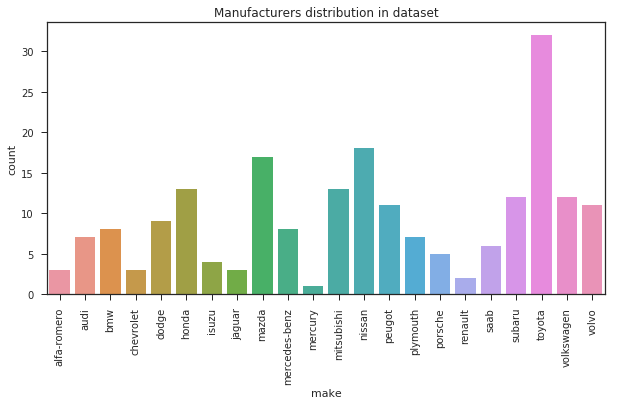

In [343]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,5))
sns.countplot(x='make', data=df_raw)
plt.xticks(rotation='vertical')
plt.title('Manufacturers distribution in dataset')
plt.show()

# It shows that the top selling car manufactorer is Toyota

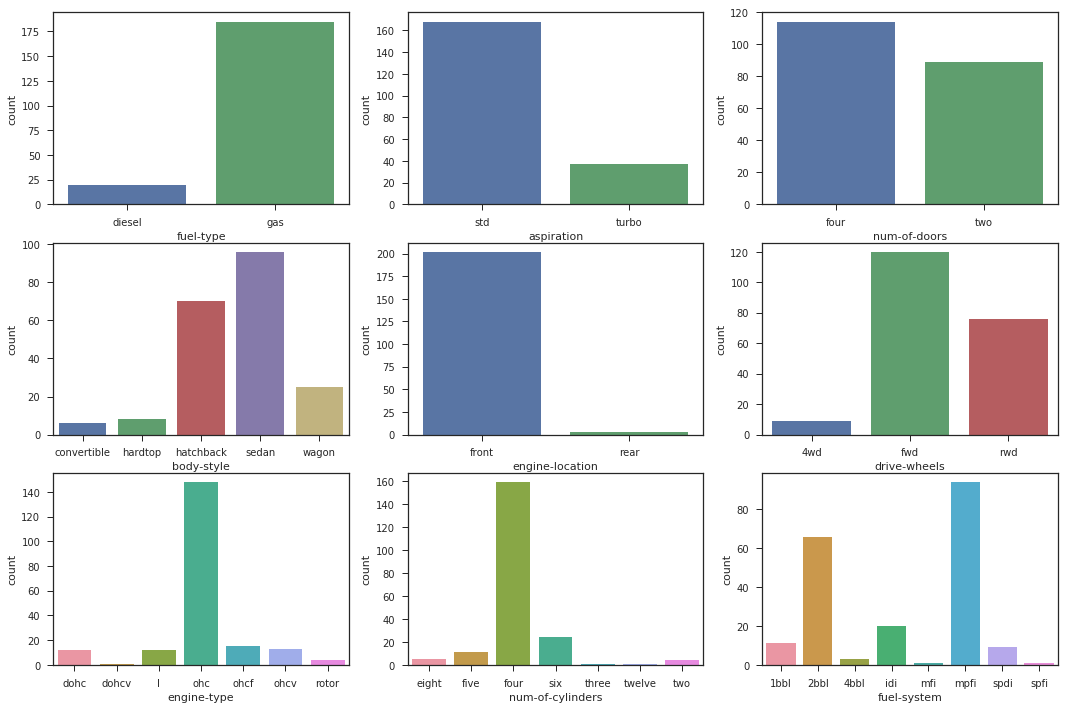

In [344]:
categorical = ['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 'engine-location',
               'drive-wheels', 'engine-type', 'num-of-cylinders', 'fuel-system']
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
for col, ax in zip(categorical[1:], axs.ravel()):
    sns.countplot(x=col, data=df_raw, ax=ax)
    

In [345]:
# convert categorical variables to their numberic representations.

for col in df_raw:
    if str(df_raw[col].dtype) == "category":
        df_raw[col] = df_raw[col].cat.codes + 1

In [346]:
df_raw.shape

(205, 32)

In [347]:
df_raw.corr()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,peak-rpm,city-mpg,highway-mpg,price,normalized-losses_na,bore_na,stroke_na,horsepower_na,peak-rpm_na,price_na
symboling,1.000000,0.457484,-0.118794,0.194311,-0.059866,0.645492,-0.596135,-0.041671,0.212471,-0.531954,...,0.273851,-0.035823,0.034606,-0.080149,0.066754,0.245950,0.245950,0.013252,0.013252,-0.037945
normalized-losses,0.457484,1.000000,-0.231427,0.104668,-0.011273,0.330122,-0.244639,0.287316,-0.021510,-0.073709,...,0.241134,-0.189530,-0.149357,0.095489,-0.088252,0.130721,0.130721,-0.017519,-0.017519,-0.024899
make,-0.118794,-0.231427,1.000000,-0.113191,0.054265,-0.127416,0.089494,-0.004317,0.054608,0.078505,...,-0.217386,0.053642,0.050022,-0.155259,-0.210412,-0.094545,-0.094545,0.060335,0.060335,-0.117081
fuel-type,0.194311,0.104668,-0.113191,1.000000,-0.401397,0.207665,-0.147853,-0.132257,0.040070,-0.308346,...,0.477507,-0.255963,-0.191392,-0.112439,-0.041100,0.046383,0.046383,0.032636,0.032636,0.046383
aspiration,-0.059866,-0.011273,0.054265,-0.401397,1.000000,-0.066737,0.063028,0.066465,-0.057191,0.257611,...,-0.184326,-0.202362,-0.254416,0.175745,0.050735,-0.066203,-0.066203,-0.046581,-0.046581,0.025497
num-of-doors,0.645492,0.330122,-0.127416,0.207665,-0.066737,1.000000,-0.670198,0.112398,0.136578,-0.416331,...,0.234101,-0.000142,0.021628,-0.036475,0.061734,0.158098,0.158098,0.014612,0.014612,0.089433
body-style,-0.596135,-0.244639,0.089494,-0.147853,0.063028,-0.670198,1.000000,-0.155745,-0.277009,0.401362,...,-0.108709,0.031697,-0.007170,-0.071614,-0.059767,-0.101176,-0.101176,0.044634,0.044634,-0.018870
drive-wheels,-0.041671,0.287316,-0.004317,-0.132257,0.066465,0.112398,-0.155745,1.000000,0.147865,0.459745,...,-0.040620,-0.449581,-0.452220,0.580367,0.254975,0.171163,0.171163,-0.058471,-0.058471,-0.083101
engine-location,0.212471,-0.021510,0.054608,0.040070,-0.057191,0.136578,-0.277009,0.147865,1.000000,-0.187790,...,0.198190,-0.153487,-0.102026,0.331459,0.243733,-0.017192,-0.017192,-0.012096,-0.012096,-0.017192
wheel-base,-0.531954,-0.073709,0.078505,-0.308346,0.257611,-0.416331,0.401362,0.459745,-0.187790,1.000000,...,-0.361338,-0.470414,-0.544082,0.584847,0.197288,-0.081174,-0.081174,-0.043896,-0.043896,-0.047709


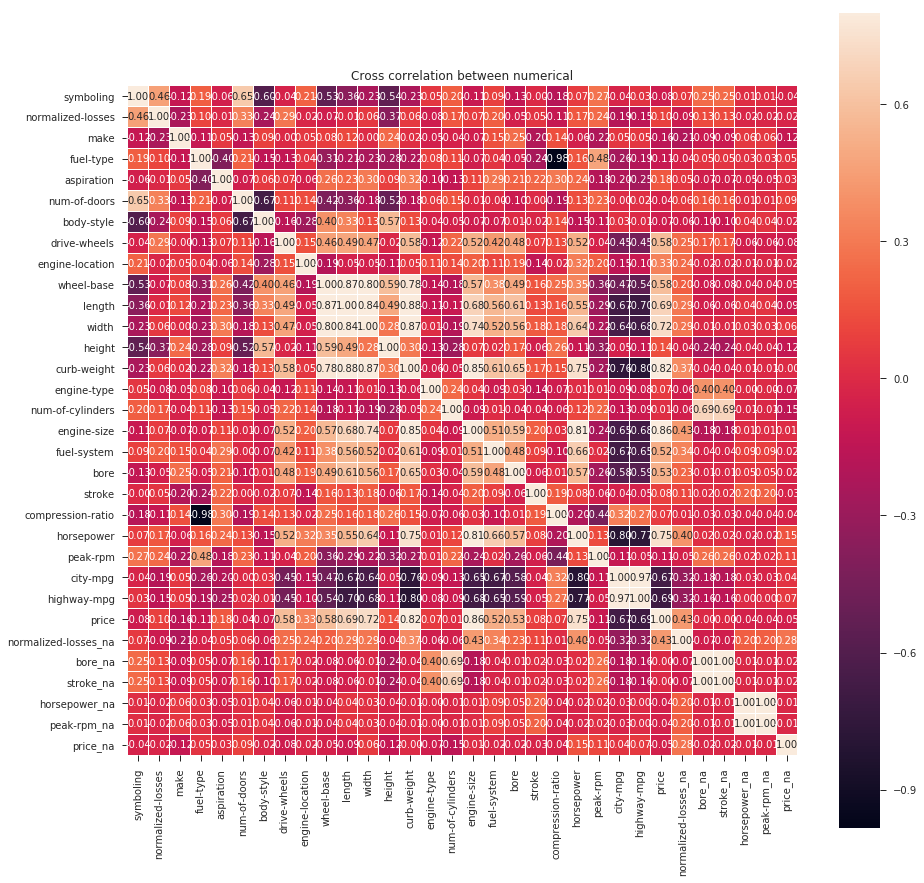

In [348]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15, 15))
ax = sns.heatmap(df_raw.corr(), vmax=.8, square=True, fmt='.2f', annot=True, linecolor='white', linewidths=0.01)
plt.title('Cross correlation between numerical')
plt.show()

# It shows that 
# - wheel-base , length , width are highly correlated. 
# - highway-mpg and city-mpg are also highly correlated. 
# - bore_na and stroke_na are highly correlated
# - horsepower_na and peak-rpm_na are highly correlated

In [349]:
df_raw.describe()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,...,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.834146,120.600000,13.195122,1.902439,1.180488,1.424390,3.614634,2.326829,1.014634,98.756585,...,126.907317,4.253659,3.329366,3.256098,10.142537,104.165854,5126.097561,25.219512,30.751220,13150.307317
std,1.245307,31.805105,6.274831,0.297446,0.385535,0.514867,0.859081,0.556171,0.120377,6.021776,...,41.642693,2.013204,0.270858,0.313634,3.972040,39.529733,477.035772,6.542142,6.886443,7879.121326
min,-2.000000,65.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,86.600000,...,61.000000,1.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,0.000000,101.000000,9.000000,2.000000,1.000000,1.000000,3.000000,2.000000,1.000000,94.500000,...,97.000000,2.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,1.000000,115.000000,13.000000,2.000000,1.000000,1.000000,4.000000,2.000000,1.000000,97.000000,...,120.000000,6.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,2.000000,137.000000,20.000000,2.000000,1.000000,2.000000,4.000000,3.000000,1.000000,102.400000,...,141.000000,6.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16500.000000
max,3.000000,256.000000,22.000000,2.000000,2.000000,2.000000,5.000000,3.000000,2.000000,120.900000,...,326.000000,8.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


In [350]:
# remove the highly correlated columns

df_uncor = df_raw.drop(['length', 'width', 'city-mpg', 'stroke_na', 'peak-rpm_na'], axis=1)
df_uncor.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,stroke,compression-ratio,horsepower,peak-rpm,highway-mpg,price,normalized-losses_na,bore_na,horsepower_na,price_na
0,3,115.0,1,2,1,2,1,3,1,88.6,...,2.68,9.0,111.0,5000.0,27,13495.0,True,False,False,False
1,3,115.0,1,2,1,2,1,3,1,88.6,...,2.68,9.0,111.0,5000.0,27,16500.0,True,False,False,False
2,1,115.0,1,2,1,2,3,3,1,94.5,...,3.47,9.0,154.0,5000.0,26,16500.0,True,False,False,False
3,2,164.0,2,2,1,1,4,2,1,99.8,...,3.40,10.0,102.0,5500.0,30,13950.0,False,False,False,False
4,2,164.0,2,2,1,1,4,1,1,99.4,...,3.40,8.0,115.0,5500.0,22,17450.0,False,False,False,False


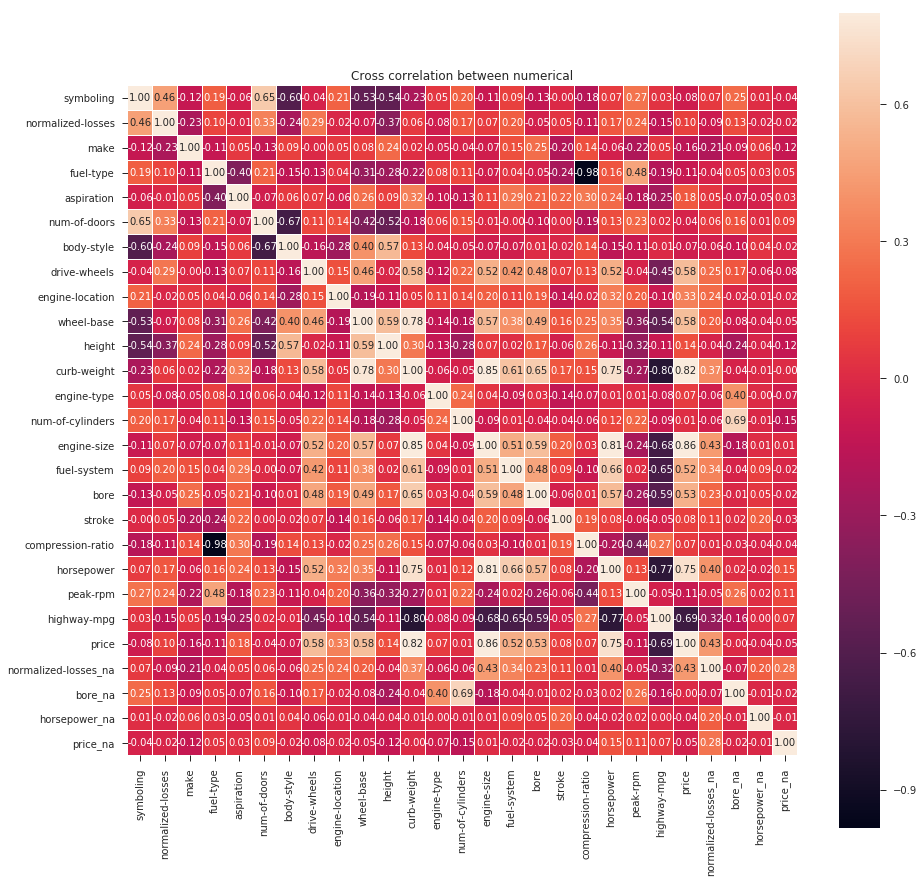

In [351]:
plt.figure(figsize=(15, 15))
ax = sns.heatmap(df_uncor.corr(), vmax=.8, square=True, fmt='.2f', annot=True, linecolor='white', linewidths=0.01)
plt.title('Cross correlation between numerical')
plt.show()

In [352]:
print(df_uncor.shape)

(205, 27)


In [353]:
df_uncor.describe()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,highway-mpg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,...,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.834146,120.600000,13.195122,1.902439,1.180488,1.424390,3.614634,2.326829,1.014634,98.756585,...,3.117073,126.907317,4.253659,3.329366,3.256098,10.142537,104.165854,5126.097561,30.751220,13150.307317
std,1.245307,31.805105,6.274831,0.297446,0.385535,0.514867,0.859081,0.556171,0.120377,6.021776,...,0.795792,41.642693,2.013204,0.270858,0.313634,3.972040,39.529733,477.035772,6.886443,7879.121326
min,-2.000000,65.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,86.600000,...,1.000000,61.000000,1.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,16.000000,5118.000000
25%,0.000000,101.000000,9.000000,2.000000,1.000000,1.000000,3.000000,2.000000,1.000000,94.500000,...,3.000000,97.000000,2.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,25.000000,7788.000000
50%,1.000000,115.000000,13.000000,2.000000,1.000000,1.000000,4.000000,2.000000,1.000000,97.000000,...,3.000000,120.000000,6.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,30.000000,10295.000000
75%,2.000000,137.000000,20.000000,2.000000,1.000000,2.000000,4.000000,3.000000,1.000000,102.400000,...,3.000000,141.000000,6.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,34.000000,16500.000000
max,3.000000,256.000000,22.000000,2.000000,2.000000,2.000000,5.000000,3.000000,2.000000,120.900000,...,7.000000,326.000000,8.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,54.000000,45400.000000


## Step 2. Predict Categorical Symboling

### Results on raw data

In [354]:
# prepare dataset

X = df_raw.drop("symboling", axis=1)
y = df_raw["symboling"].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((164, 31), (41, 31), (164,), (41,))

- Random Forest

In [355]:
# train a randomforest classifier

clf = RandomForestClassifier(n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [356]:
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)

print('train score: {}'.format(round(train_score, 3)))
print('test score: {}'.format(round(test_score, 3)))

train score: 0.988
test score: 0.756


#### It shows that with random forest classifier, the mean accuracy on the test set is 0.756

- Gradient Boost Machine

In [357]:
#Ref https://machinelearningmastery.com/xgboost-python-mini-course/

# fit model on training data
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [358]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)

print('accuracy: {}'.format(round(accuracy, 3)))

accuracy: 0.805


/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### It shows that the gradient boost machine, the mean accuracy on the test set is 0.805 which is better than the accuracy achieved with random forest

In [367]:
# hyperparameter tuning
# reference: 
# https://machinelearningmastery.com/xgboost-python-mini-course/
# https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost/code
# https://xgboost-clone.readthedocs.io/en/latest/parameter.html

def timer(start_time=None):
    # fork from https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
        
folds = 5
param_comb = 5

xgb_clf = XGBClassifier(silent=True)
params = {
            'n_estimators': [5, 50, 100, 200],
            #'min_child_weight': [1, 5, 10],
            # 'gamma': [0.5, 1, 1.5, 2, 5],
            # 'subsample': [0.6, 0.8, 1.0],
            #'subsample': [0.6, 0.8, 1],
            # 'colsample_bytree': [0.6, 0.8, 1.0],
            # 'colsample_bytree': [0.6, 0.8, 1],
            # 'max_depth': [3, 4, 5]
            'max_depth': [2, 4, 6],
        }

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

search = RandomizedSearchCV(xgb_clf, 
                                   param_distributions=params, 
                                   n_iter=param_comb, 
                                   #scoring='roc_auc', # binary classification
                                   scoring='accuracy',
                                   n_jobs=-1,
                                   cv=skf.split(X_train, y_train),
                                   verbose=3, random_state=42)

# search = GridSearchCV(model, params, scoring="neg_log_loss", n_jobs=-1, cv=skf)

start_time = timer(None)
search.fit(X_train, y_train)
timer(start_time)

print('--------------')
print('\n all results:')
print(search.cv_results_)

print('\n best estimator:')
print(search.best_estimator_)

print('\n best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(search.best_score_ * 2 - 1)

print('\n best xgb hyperparameters:')
print(search.best_params_)

result_csv_path = 'xgb-search-results.csv'
results = pd.DataFrame(search.cv_results_)
results.to_csv(result_csv_path, index=False)
print('save xgb search results to {}'.format(result_csv_path))
print('--------------')

#y_pred = search.predict_proba(X_test)
#y_pred = np.argmax(y_pred)
y_pred = search.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)

print('accuracy: {}'.format(round(accuracy, 3)))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[CV] n_estimators=100, max_depth=6 ...................................
[CV] n_estimators=100, max_depth=6 ...................................
[CV] n_estimators=100, max_depth=6 ...................................
[CV] n_estimators=100, max_depth=6 ...................................


/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=100, max_depth=6, score=0.8055555555555556, total=   0.2s
[CV] n_estimators=100, max_depth=6 ...................................


/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=100, max_depth=6, score=0.7647058823529411, total=   0.3s
[CV] n_estimators=50, max_depth=6 ....................................


/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ...... n_estimators=100, max_depth=6, score=0.8125, total=   0.3s
[CV] n_estimators=50, max_depth=6 ....................................


/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....... n_estimators=100, max_depth=6, score=0.875, total=   0.4s
[CV] n_estimators=50, max_depth=6 ....................................


/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

[CV] ......... n_estimators=100, max_depth=6, score=0.9, total=   0.3s
[CV]  n_estimators=50, max_depth=6, score=0.7777777777777778, total=   0.2s
[CV] n_estimators=50, max_depth=6 ....................................
[CV] n_estimators=50, max_depth=6 ....................................


/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=50, max_depth=6, score=0.7941176470588235, total=   0.3s
[CV] n_estimators=5, max_depth=2 .....................................


/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=50, max_depth=6, score=0.8666666666666667, total=   0.2s


/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] n_estimators=5, max_depth=2 .....................................
[CV]  n_estimators=5, max_depth=2, score=0.5833333333333334, total=   0.0s


/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] n_estimators=5, max_depth=2 .....................................


/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ........ n_estimators=50, max_depth=6, score=0.875, total=   0.2s


/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=5, max_depth=2, score=0.5588235294117647, total=   0.0s
[CV] n_estimators=5, max_depth=2 .....................................
[CV] n_estimators=5, max_depth=2 .....................................


/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ........ n_estimators=5, max_depth=2, score=0.6875, total=   0.0s
[CV] n_estimators=5, max_depth=6 .....................................


/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=5, max_depth=2, score=0.5333333333333333, total=   0.0s
[CV] n_estimators=5, max_depth=6 .....................................


/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] .......... n_estimators=5, max_depth=2, score=0.75, total=   0.0s
[CV] n_estimators=5, max_depth=6 .....................................


/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

[CV] ....... n_estimators=50, max_depth=6, score=0.8125, total=   0.4s
[CV]  n_estimators=5, max_depth=6, score=0.7777777777777778, total=   0.0s


/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] n_estimators=5, max_depth=6 .....................................


/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=5, max_depth=6, score=0.6470588235294118, total=   0.0s
[CV] n_estimators=5, max_depth=6 .....................................
[CV] n_estimators=50, max_depth=4 ....................................


/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....... n_estimators=5, max_depth=6, score=0.90625, total=   0.0s
[CV] n_estimators=50, max_depth=4 ....................................


/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=5, max_depth=6, score=0.8333333333333334, total=   0.0s
[CV] n_estimators=50, max_depth=4 ....................................


/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ........ n_estimators=5, max_depth=6, score=0.6875, total=   0.1s
[CV] n_estimators=50, max_depth=4 ....................................


/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ...... n_estimators=50, max_depth=4, score=0.90625, total=   0.1s


/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] n_estimators=50, max_depth=4 ....................................


/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ....... n_estimators=50, max_depth=4, score=0.8125, total=   0.2s
[CV]  n_estimators=50, max_depth=4, score=0.7352941176470589, total=   0.2s


/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=50, max_depth=4, score=0.8055555555555556, total=   0.3s


/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  n_estimators=50, max_depth=4, score=0.8666666666666667, total=   0.1s


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.4s finished



 Time taken: 0 hours 0 minutes and 1.85 seconds.
--------------

 all results:
{'mean_fit_time': array([0.29460716, 0.24226031, 0.01558509, 0.02513766, 0.17172489]), 'std_fit_time': array([0.0507163 , 0.08981774, 0.00366838, 0.00400893, 0.04409415]), 'mean_score_time': array([0.01750584, 0.01464481, 0.01189084, 0.01178408, 0.01264663]), 'std_score_time': array([0.00792284, 0.00758048, 0.00560889, 0.00992907, 0.01301955]), 'param_n_estimators': masked_array(data=[100, 50, 5, 5, 50],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[6, 6, 2, 6, 4],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 100, 'max_depth': 6}, {'n_estimators': 50, 'max_depth': 6}, {'n_estimators': 5, 'max_depth': 2}, {'n_estimators': 5, 'max_depth': 6}, {'n_estimators': 50, 'max_depth': 4}], 'split0_test_score': array([0.80555556, 0.77777

/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/kchen/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/kchen/anaconda3/lib/python3.6/

### Summary


It shows that on the raw features with random forest (with default parameters), I achieved 0.756 mean accuracy on the test set. With gradient boost machine (with defualt parameters), the mean accuracy on the test set is 0.805. With hyperparameter tuning, the mean accuracy is 0.829 which is improved.

## Results on removed highly correlated features

In [317]:
#prepare datasets

X = df_uncor.drop("symboling", axis=1)
y = df_uncor["symboling"].astype('category')

X_train_uncor, X_test_uncor, y_train_uncor, y_test_uncor = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train_uncor.shape, X_test_uncor.shape, y_train_uncor.shape, y_test_uncor.shape

((164, 26), (41, 26), (164,), (41,))

- Random Forest

In [318]:
clf = RandomForestClassifier(n_jobs=-1)
clf.fit(X_train_uncor, y_train_uncor)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [319]:
train_score = clf.score(X_train_uncor, y_train_uncor)
val_score = clf.score(X_test_uncor, y_test_uncor)

print('train score: {}'.format(round(train_score, 3)))
print('validation score: {}'.format(round(val_score, 3)))

train score: 0.988
validation score: 0.756


In [50]:
def plot_performance(x_list, y_list, title, x_label, y_label):
    """
    define the plotting function
    """
    plt.plot(x_list, y_list)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

- RandomForest Hyperparameter tuning

In [320]:
# parameter tuning
# Tune three parameters: n_estimators, min_samepls_leaf, and max_features

numOfestimators = [1, 10, 20, 100]
numOfleafs = [1, 2, 4, 8]
numOffeatures = np.arange(0.1, 1, 0.2)

train_scores = []
val_scores = []
best_result = []

for numOfestimator in numOfestimators:
    for numOfleaf in numOfleafs:
        for numOffeature in numOffeatures:  
            clf = RandomForestClassifier(n_jobs=-1, n_estimators=numOfestimator,
                                         min_samples_leaf=numOfleaf, max_features=numOffeature)
            # print(result)
            clf.fit(X_train_uncor, y_train_uncor)
            
            train_score = round(clf.score(X_train_uncor, y_train_uncor), 3)
            train_scores.append(train_score)
            
            val_score = round(clf.score(X_test_uncor, y_test_uncor), 3)
            val_scores.append(val_score)
            
            result = [numOfestimator, numOfleaf, numOffeature]
            result.append(train_score)
            result.append(val_score)
            
            if len(best_result) == 0: best_result = result
            elif best_result[4] < result[4]: 
                best_result = result
            
            print('\nnum of estimator: {}  num of leaf: {}  num of features: {}'.format(numOfestimator, numOfleaf, numOffeature))
            print('train score: {}  val score: {}'.format(train_score, val_score))
            
print('\nfinal score')
print('num of estimators, num of leafs, num of features, train score, test score')
print(best_result)            
# plot_performance(train_scores, val_scores, 'train scores', 'validation scores', 'accuracy')


num of estimator: 1  num of leaf: 1  num of features: 0.1
train score: 0.872  val score: 0.683

num of estimator: 1  num of leaf: 1  num of features: 0.30000000000000004
train score: 0.878  val score: 0.683

num of estimator: 1  num of leaf: 1  num of features: 0.5000000000000001
train score: 0.866  val score: 0.61

num of estimator: 1  num of leaf: 1  num of features: 0.7000000000000001
train score: 0.89  val score: 0.732

num of estimator: 1  num of leaf: 1  num of features: 0.9000000000000001
train score: 0.866  val score: 0.61

num of estimator: 1  num of leaf: 2  num of features: 0.1
train score: 0.768  val score: 0.585

num of estimator: 1  num of leaf: 2  num of features: 0.30000000000000004
train score: 0.793  val score: 0.659

num of estimator: 1  num of leaf: 2  num of features: 0.5000000000000001
train score: 0.805  val score: 0.634

num of estimator: 1  num of leaf: 2  num of features: 0.7000000000000001
train score: 0.823  val score: 0.683

num of estimator: 1  num of lea


num of estimator: 100  num of leaf: 8  num of features: 0.30000000000000004
train score: 0.823  val score: 0.683

num of estimator: 100  num of leaf: 8  num of features: 0.5000000000000001
train score: 0.817  val score: 0.659

num of estimator: 100  num of leaf: 8  num of features: 0.7000000000000001
train score: 0.872  val score: 0.634

num of estimator: 100  num of leaf: 8  num of features: 0.9000000000000001
train score: 0.823  val score: 0.659

final score
num of estimators, num of leafs, num of features, train score, test score
[10, 1, 0.7000000000000001, 1.0, 0.829]


## Step 3. Predict Price

### Results on raw data

In [321]:
# prepare datasets

X = df_raw.drop('price', axis=1)
y = df_raw['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((164, 31), (41, 31), (164,), (41,))

In [322]:
clf = RandomForestRegressor(n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [323]:
def rmse(preds, actuals):
    return math.sqrt(((preds-actuals)**2).mean())

In [324]:
rmse_train = rmse(clf.predict(X_train), y_train)
rmse_test = rmse(clf.predict(X_test), y_test)
score_train = clf.score(X_train, y_train)
score_test = clf.score(X_test, y_test)

print('train rmse: {}'.format(round(rmse_train, 3)))
print('test rmse: {}'.format(round(rmse_test, 3)))
print('train score: {}'.format(round(score_train, 3)))
print('test score: {}'.format(round(score_test, 3)))

train rmse: 1427.393
test rmse: 2794.68
train score: 0.965
test score: 0.9


### Results on removed highly correlated features

In [325]:
X = df_uncor.drop('price', axis=1)
y = df_uncor['price']

X_train_uncor, X_test_uncor, y_train_uncor, y_test_uncor = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train_uncor.shape, X_test_uncor.shape, y_train_uncor.shape, y_test_uncor.shape

((164, 26), (41, 26), (164,), (41,))

In [326]:
clf = RandomForestRegressor(n_jobs=-1)
clf.fit(X_train_uncor, y_train_uncor)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [327]:
rmse_train = rmse(clf.predict(X_train_uncor), y_train_uncor)
rmse_test = rmse(clf.predict(X_test_uncor), y_test_uncor)
score_train = clf.score(X_train_uncor, y_train_uncor)
score_test = clf.score(X_test_uncor, y_test_uncor)

print('train rmse: {}'.format(round(rmse_train, 3)))
print('test rmse: {}'.format(round(rmse_test, 3)))
print('train score: {}'.format(round(score_train, 3)))
print('test score: {}'.format(round(score_test, 3)))

train rmse: 1488.023
test rmse: 2639.997
train score: 0.962
test score: 0.911


In [328]:
regressor = LinearRegression()
lm = regressor.fit(X_train_uncor, y_train_uncor)

rmse_train = rmse(lm.predict(X_train_uncor), y_train_uncor)
rmse_test = rmse(lm.predict(X_test_uncor), y_test_uncor)
score_train = lm.score(X_train_uncor, y_train_uncor)
score_test = lm.score(X_test_uncor, y_test_uncor)

print('train rmse: {}'.format(round(rmse_train, 3)))
print('test rmse: {}'.format(round(rmse_test, 3)))
print('train score: {}'.format(round(score_train, 3)))
print('test score: {}'.format(round(score_test, 3)))

train rmse: 2394.947
test rmse: 3841.471
train score: 0.9
test score: 0.812


In [329]:
normalizer = Normalizer()
X_train_uncor_norm = normalizer.fit_transform(X_train_uncor)
X_test_uncor_norm = normalizer.transform(X_test_uncor)

lm_norm = regressor.fit(X_train_uncor_norm, y_train_uncor)

rmse_train = rmse(lm_norm.predict(X_train_uncor_norm), y_train_uncor)
rmse_test = rmse(lm_norm.predict(X_test_uncor_norm), y_test_uncor)
score_train = lm_norm.score(X_train_uncor_norm, y_train_uncor)
score_test = lm_norm.score(X_test_uncor_norm, y_test_uncor)

print('train rmse: {}'.format(round(rmse_train, 3)))
print('test rmse: {}'.format(round(rmse_test, 3)))
print('train score: {}'.format(round(score_train, 3)))
print('test score: {}'.format(round(score_test, 3)))


train rmse: 2632.898
test rmse: 3902.105
train score: 0.88
test score: 0.806


## Question 1
List as many use cases for the dataset as possible.

Answer:
* symboling prediction
* price prediction
* car clustering


## Question 2
Auto1 has a similar dataset (yet much larger...) 
Pick one of the use cases you listed in question 1 and describe how building a statistical model based on the dataset could best be used to improve Auto1’s business.

Answer:
I would pick the price prediction. The details of how I build the price prediction model are given in previous parts of the notebook.  

As reported in the article (https://www.linkedin.com/pulse/billion-dollar-unicorn-auto1-what-its-margins-sramana-mitra/), AUTO1 Group aims to build a stock exchange for used cars, using technology to seamlessly connect buyers with seller. Therefore, it is crucial to have a model which could predict the prices of the cars in order to maximize the difference between the buying prices and selling prices. To this end, machine learning is the most suitable solution, based on the historical data and sophicasted machine learning (or deep learning) algorithms, I believe the goal can be achieved.  


## Question 3
Implement the model you described in question 2 in R or Python. The code has to retrieve the data, train and test a statistical model, and report relevant performance criteria.

Answer:
Please refer to the above steps.


## Question 4
A. Explain each and every of your design choices (e.g., preprocessing, model selection, hyper parameters, evaluation criteria). Compare and contrast your choices with alternative methodologies. 

Answer:
Please refer to the previous steps.

B. Describe how you would improve the model in Question 3 if you had more time.

Answer:
The future work includes:
- Comparison of different models, e.g., xgboost, catboost, lightxgb, randomforest, svm, linear regression.
- Blending
- Hyperparameters tuning
- Early stopping during training
- Feature selection
- Feature engineering
- Deep learning, e.g., convolutional neural networks (if I have the large-scale data)
- Car clustering with unsupervised machine learning algorithms, e.g., k-means, autoencoder

